SUCCESS: 'prophet' library imported.
Data prepared. Found 1334 months.
Training set: 1910-08-31 00:00:00 -> 2018-09-30 00:00:00 (1298 months)
Test set: 2018-10-31 00:00:00 -> 2021-09-30 00:00:00 (36 months)


23:28:32 - cmdstanpy - INFO - Chain [1] start processing
23:28:32 - cmdstanpy - INFO - Chain [1] done processing



--- Forecast Data (Last 5 Rows) ---
             ds      yhat  yhat_lower  yhat_upper
1329 2021-05-31  6.773075    4.400859    9.081829
1330 2021-06-30  7.678379    5.426471    9.852639
1331 2021-07-31  8.555067    6.260613   10.836943
1332 2021-08-31  8.242587    6.109599   10.618667
1333 2021-09-30  7.066003    4.977068    9.345789


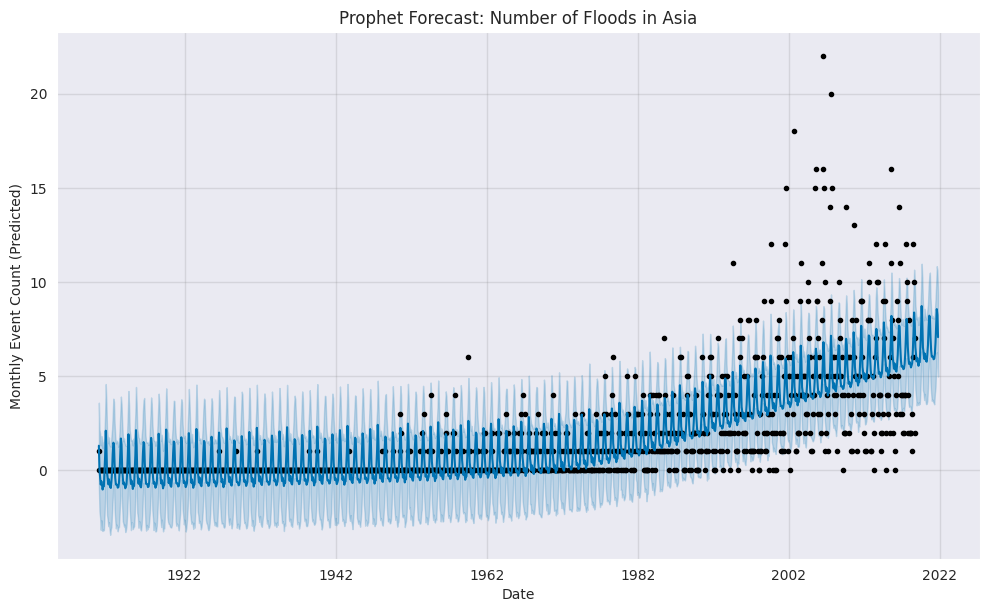

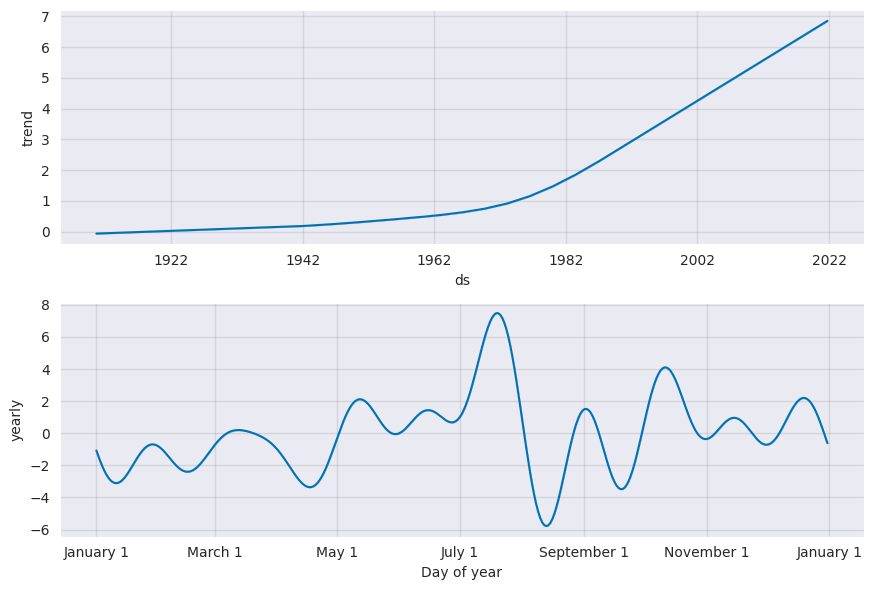

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Import the Prophet Library ---
# (Assuming the previous step 'pip install prophet' was successful)
try:
    from prophet import Prophet
    from prophet.plot import plot_plotly, plot_components_plotly
    print("SUCCESS: 'prophet' library imported.")
except ImportError:
    print("ERROR: 'prophet' library not found.")
    print("Please run 'pip install prophet' in the terminal and restart the kernel.")
    # raise

# --- 2. Data Preparation from Step 22 ---
# (Copying all that 'resample' code again so this notebook can run standalone)

file_path = "../1900_2021_DISASTERS.xlsx - emdat data.csv"
df_raw = pd.read_csv(file_path)

# Engineering
continent_filter = "Asia"
disaster_type_filter = "Flood"
df_filtered = df_raw[
    (df_raw['Continent'] == continent_filter) &
    (df_raw['Disaster Type'] == disaster_type_filter)
].copy()
df_filtered['Start Day'] = 1
df_filtered = df_filtered.dropna(subset=['Start Year', 'Start Month'])
df_filtered['datetime'] = pd.to_datetime(
    df_filtered[['Start Year', 'Start Month', 'Start Day']].rename(
        columns={'Start Year': 'year', 'Start Month': 'month', 'Start Day': 'day'}
    )
)
df_ts = df_filtered.set_index('datetime')
ts_df = df_ts.resample('ME').size().fillna(0)
ts_df = ts_df.reset_index()
ts_df.columns = ['ds', 'y'] # Prophet format

print(f"Data prepared. Found {len(ts_df)} months.")

# --- 3. Time Series Data Splitting (Train/Test Split) ---
# CRITICAL LESSON (Manifesto 2.5: Solid ML Fundamentals)
# NEVER use 'train_test_split(..., random_state=42)' for time series.
# Shuffling time is forbidden.
# We must use the "Past" (e.g., up to 2019) to predict the "Future" (post-2019).

# Let's separate the last 3 years (36 months) as the 'test' set
test_months = 36
train_df = ts_df.iloc[:-test_months] # ALL except the last 36 months
test_df = ts_df.iloc[-test_months:]  # ONLY the last 36 months

print(f"Training set: {train_df['ds'].min()} -> {train_df['ds'].max()} ({len(train_df)} months)")
print(f"Test set: {test_df['ds'].min()} -> {test_df['ds'].max()} ({len(test_df)} months)")


# --- 4. Training the Prophet Model ---
# Prophet uses automatic settings for 'trend' (your 4.1 observation)
# and 'seasonality' (your 4.2 observation).
m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m.fit(train_df) # Train the model ONLY on 'train' data

# --- 5. Forecasting ---
# 'make_future_dataframe' gives Prophet the dates (ds) of our 'test' set
# (the last 36 months).
future = m.make_future_dataframe(periods=test_months, freq='ME') # Ensure we use 'ME' (Month End)
forecast = m.predict(future)

print("\n--- Forecast Data (Last 5 Rows) ---")
# The 'forecast' object is very large, it includes 'yhat' (prediction),
# 'yhat_lower' (lower bound), and 'yhat_upper' (upper bound)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


# --- 6. Visualization: Forecast ---
# This compares the model's prediction (blue line) against the actual data (black dots)
fig1 = m.plot(forecast)
plt.title("Prophet Forecast: Number of Floods in Asia")
plt.xlabel("Date")
plt.ylabel("Monthly Event Count (Predicted)")
plt.show()

# --- 7. Visualization: Components ---
# THIS IS THE MOST IMPORTANT GRAPH.
# It "decomposes" your 4.1 and 4.2 observations.
fig2 = m.plot_components(forecast)
plt.show()

In [4]:
import os
import json

# --- 1. Import Prophet's Serialization Library ---
try:
    from prophet.serialize import model_to_json, model_from_json
    print("SUCCESS: Prophet serialization (JSON) tools imported.")
except ImportError:
    print("ERROR: Prophet serialization tools not found. Is the library up to date?")
    # raise
except Exception as e:
    print(f"Unknown error: {e}")

# --- 2. Save Path ---
# (Our 'models' directory from Problem 1 and 2 should already exist)
model_directory = "../models"
model_file_path = os.path.join(model_directory, "timeseries_model_v1.json")

# --- 3. Save the Model (Prophet object 'm') ---
# We assume the 'm' object is in memory from the previous (training) cell.

print(f"Saving Time Series (Prophet) model to the path: {model_file_path}")
try:
    # m = model object
    model_json_data = model_to_json(m)

    with open(model_file_path, 'w') as f_out:
        f_out.write(model_json_data)

    print("SUCCESS: Model saved as 'timeseries_model_v1.json'.")

except NameError:
    print("ERROR: Model object named 'm' not found in memory.")
    print("Please ensure you have successfully run the previous (training) cell.")
except Exception as e:
    print(f"ERROR during model saving: {e}")


# --- 4. (Optional) Check That the Model is Loaded Back ---
print("\nLet's test by loading the model back (JSON)...")
try:
    with open(model_file_path, 'r') as f_in:
        m_loaded = model_from_json(f_in.read())

    print("SUCCESS: Model loaded from JSON.")
    # (Prophet models cannot make predictions immediately after loading,
    # they only show components, so we are not performing a prediction test)

except Exception as e:
    print(f"ERROR while loading model from JSON: {e}")

SUCCESS: Prophet serialization (JSON) tools imported.
Saving Time Series (Prophet) model to the path: ../models/timeseries_model_v1.json
SUCCESS: Model saved as 'timeseries_model_v1.json'.

Let's test by loading the model back (JSON)...
SUCCESS: Model loaded from JSON.
